In [2]:
from pathlib import Path
import pandas as pd
import mne
import numpy as np
from HFODetector import ste  # or mni, if you prefer

In [ ]:
demog = pd.read_csv("data/ds004100/participants.tsv", sep='\t')
all_runs = pd.read_csv('all_runs.csv')
demog.head()
df = all_runs.merge(
    demog,
    left_on="subject",
    right_on="participant_id",
    how="left"
)


print(df.head())

df[['age','hfo_rate']].corr(method='spearman')

      subject     run  n_hfos  duration_s  hfo_rate participant_id   age sex  \
0  sub-HUP089  run-01       6       289.0  0.020761     sub-HUP089  29.0   M   
1  sub-HUP089  run-02      41       243.0  0.168724     sub-HUP089  29.0   M   
2  sub-HUP089  run-03      32       272.0  0.117647     sub-HUP089  29.0   M   
3  sub-HUP089  run-04      20       256.0  0.078125     sub-HUP089  29.0   M   
4  sub-HUP087  run-01       7       214.0  0.032710     sub-HUP087  24.0   M   

  hand outcome engel    therapy implant    target lesion_status  age_onset  
0  NaN       S    1B  RESECTION    ECOG  TEMPORAL      LESIONAL       23.0  
1  NaN       S    1B  RESECTION    ECOG  TEMPORAL      LESIONAL       23.0  
2  NaN       S    1B  RESECTION    ECOG  TEMPORAL      LESIONAL       23.0  
3  NaN       S    1B  RESECTION    ECOG  TEMPORAL      LESIONAL       23.0  
4    L       S    1D  RESECTION    ECOG   FRONTAL      LESIONAL       19.0  


,age,n_hfos
age,1.000000,0.080107
n_hfos,0.080107,1.000000


In [5]:
import statsmodels.formula.api as smf

# univariate
m1 = smf.ols("hfo_rate ~ age", data=df).fit()
print(m1.summary())

                            OLS Regression Results                            
Dep. Variable:               hfo_rate   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     6.479
Date:                Thu, 31 Jul 2025   Prob (F-statistic):             0.0117
Time:                        07:33:12   Log-Likelihood:                -259.76
No. Observations:                 203   AIC:                             523.5
Df Residuals:                     201   BIC:                             530.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0174      0.216      4.705      0.0

In [6]:
#log transform

smf.ols("np.log(hfo_rate+1e-3) ~ age", data=df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     np.log(hfo_rate + 1e-3)   R-squared:                       0.000
Model:                                 OLS   Adj. R-squared:                 -0.005
Method:                      Least Squares   F-statistic:                   0.01329
Date:                     Thu, 31 Jul 2025   Prob (F-statistic):              0.908
Time:                             07:34:25   Log-Likelihood:                -376.12
No. Observations:                      203   AIC:                             756.2
Df Residuals:                          201   BIC:                             762.9
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.5373      0.384     -4.007      0.000      -2.294      -0.781
age           -0.0012      0.011     -0.115      0.908      -0.023       0.020
==============================================================================
Omnibus:                       46.750   Durbin-Watson:                   1.297
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               88.891
Skew:                          -1.131   Prob(JB):                     4.98e-20
Kurtosis:                       5.322   Cond. No.                         125.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
import statsmodels.api as sm

# 1) Pick only the columns you need & copy
df_model = df[['n_hfos','duration_s','age']].copy()

# 2) Replace zeros in duration (if any) with NaN so they’ll be dropped
df_model.loc[df_model.duration_s == 0, 'duration_s'] = np.nan

# 3) Convert any ±inf to NaN
df_model.replace([np.inf, -np.inf], np.nan, inplace=True)

# 4) Drop all rows with any NaN
df_model = df_model.dropna()
print(f"Kept {len(df_model)} out of {len(df)} runs for modeling")

# 5) Build the GLM
y      = df_model['n_hfos']
X      = sm.add_constant(df_model['age'])
offset = np.log(df_model['duration_s'])

poisson = sm.GLM(
    y,
    X,
    family=sm.families.Poisson(),
    offset=offset,
    missing='drop'   # double‐ensure missing data are removed
).fit()

print(poisson.summary())

Kept 203 out of 208 runs for modeling
                 Generalized Linear Model Regression Results                  
Dep. Variable:                 n_hfos   No. Observations:                  203
Model:                            GLM   Df Residuals:                      201
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -18065.
Date:                Thu, 31 Jul 2025   Deviance:                       34946.
Time:                        07:39:22   Pearson chi2:                 6.50e+04
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         

In [12]:
# prepare data as before, with no missing or zero‐duration rows
y      = df_model['n_hfos']
X      = sm.add_constant(df_model['age'])
offset = np.log(df_model['duration_s'])

nb = sm.GLM(
    y,
    X,
    family=sm.families.NegativeBinomial(alpha=1.0),
    offset=offset
).fit()

print(nb.summary())
print("Dispersion (Pearson χ²/df):", nb.pearson_chi2/nb.df_resid)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 n_hfos   No. Observations:                  203
Model:                            GLM   Df Residuals:                      201
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1184.2
Date:                Thu, 31 Jul 2025   Deviance:                       325.70
Time:                        07:40:43   Pearson chi2:                     468.
No. Iterations:                     8   Pseudo R-squ. (CS):            0.08973
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2261      0.248      0.910      0.3

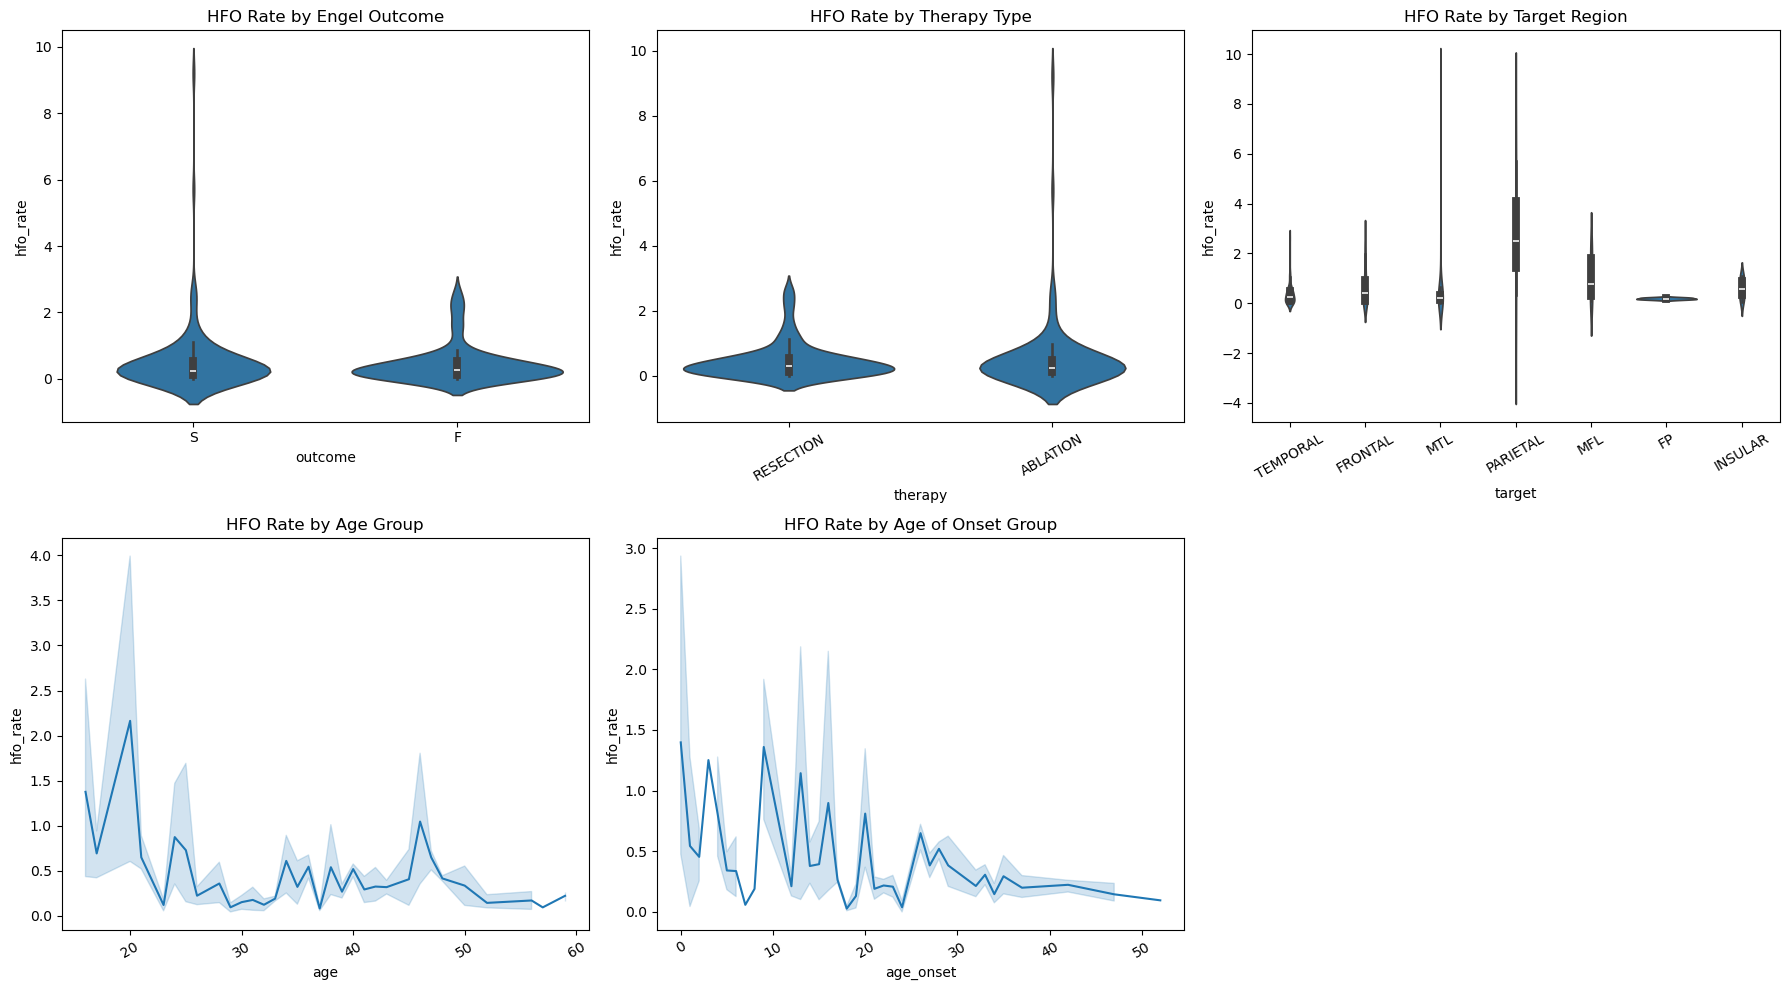

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# assume df is your merged DataFrame with columns:
# ['hfo_rate','outcome','therapy','target','age','age_onset',...]

# 2) set up a grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# 3) violin for each:
sns.violinplot(data=df, x='outcome',     y='hfo_rate', ax=axes[0])
axes[0].set_title('HFO Rate by Engel Outcome')

sns.violinplot(data=df, x='therapy',     y='hfo_rate', ax=axes[1])
axes[1].set_title('HFO Rate by Therapy Type')
axes[1].tick_params(axis='x', rotation=30)

sns.violinplot(data=df, x='target',      y='hfo_rate', ax=axes[2])
axes[2].set_title('HFO Rate by Target Region')
axes[2].tick_params(axis='x', rotation=30)

sns.lineplot(data=df, x='age',     y='hfo_rate', ax=axes[3])
axes[3].set_title('HFO Rate by Age Group')
axes[3].tick_params(axis='x', rotation=30)

sns.lineplot(data=df, x='age_onset',   y='hfo_rate', ax=axes[4])
axes[4].set_title('HFO Rate by Age of Onset Group')
axes[4].tick_params(axis='x', rotation=30)

# 5) hide the unused subplot
axes[5].axis('off')

plt.tight_layout()
plt.show()